In [1]:
import crispr_hmm
from Bio import SeqIO
import random
import matplotlib.pyplot as plt
import numpy as np
from Bio import pairwise2
import csv
import pandas as pd
from collections import Counter

/homes8/jingyuan/.local/lib/python3.9/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [2]:
ref = "ACACCATGGTGCATCTGACTCCTGTGGAGAAGTCTGCCGTTACTGCCCTG"
HMM_result = pd.read_csv("./output/nhej_HMM_result.csv")
NW_result = pd.read_csv("./output/nhej_NW_result.csv")

In [13]:
counter = Counter(list(HMM_result["aligned_read"]))

top_10_sequences = sorted(counter.items(), key=lambda x: x[1], reverse=True)[:10]
top_10_sequences = [i for i in top_10_sequences if i[0] != ref]

print("ref    " + ref)
for s in top_10_sequences:
    print("{:.1%}".format(s[1]/len(HMM_result)) + " "*(7-len("{:.1%}".format(s[1]/len(HMM_result))))
          + s[0])

ref    ACACCATGGTGCATCTGACTCCTGTGGAGAAGTCTGCCGTTACTGCCCTG
24.5%  ACACCATGGTGCATCTGACTC-TGTGGAGAAGTCTGCCGTTACTGCCCTG
7.0%   ACACCATGGTGCATCTG-------TGGAGAAGTCTGCCGTTACTGCCCTG
3.5%   ACACCATGGTGCATCTGACT---GTGGAGAAGTCTGCCGTTACTGCCCTG
2.4%   ACACCATGGTGCATCTGACTCCCTGTGGAGAAGTCTGCCGTTACTGCCCTG
1.9%   ACACCATGGTGCATCTGACTC--GTGGAGAAGTCTGCCGTTACTGCCCTG
1.1%   ACACCATGGTGCATCTGACTCTCCTGTGGAGAAGTCTGCCGTTACTGCCCTG
0.8%   ACACCATG---------------GTGGAGAAGTCTGCCGTTACTGCCCTG
0.8%   ACACCATGGTGCATCTG----CTGTGGAGAAGTCTGCCGTTACTGCCCTG
0.7%   ACACCATGGTGCATCTG-------------------CCGTTACTGCCCTG


In [16]:
counter = Counter(list(NW_result["aligned_read"]))

top_10_sequences = sorted(counter.items(), key=lambda x: x[1], reverse=True)[:10]
top_10_sequences = [i for i in top_10_sequences if i[0] != ref]

print(ref)
for s in top_10_sequences:
    print(s[0] + " "*(53-len(s[0]))
          + "{:.1%}".format(s[1]/len(NW_result)))

ACACCATGGTGCATCTGACTCCTGTGGAGAAGTCTGCCGTTACTGCCCTG
ACACCATGGTGCATCTGACT-CTGTGGAGAAGTCTGCCGTTACTGCCCTG   12.3%
ACACCATGGTGCATCTGACTC-TGTGGAGAAGTCTGCCGTTACTGCCCTG   12.3%
ACACCATGGTGCATCTGACTCCCTGTGGAGAAGTCTGCCGTTACTGCCCTG  2.4%
ACACCATGGTGCATCTGACTC--GTGGAGAAGTCTGCCGTTACTGCCCTG   1.9%
ACACCATGGTGCATC-------TGTGGAGAAGTCTGCCGTTACTGCCCTG   1.8%
ACACCATGGTGCAT-------CTGTGGAGAAGTCTGCCGTTACTGCCCTG   1.8%
ACACCATGGTGCATCT-------GTGGAGAAGTCTGCCGTTACTGCCCTG   1.8%
ACACCATGGTGCATCTG-------TGGAGAAGTCTGCCGTTACTGCCCTG   1.7%
ACACCATGGTGCATCTGA---CTGTGGAGAAGTCTGCCGTTACTGCCCTG   1.2%


In [12]:
import gzip

file_path = "./output/CRISPResso/CRISPResso_on_nhej_real/real.CRISPResso_output.fastq.gz"

CRISPResso_result_fq = []

with gzip.open(file_path, "r") as file:
    while True:
        line1 = file.readline()
        line2 = file.readline()
        line3 = file.readline()
        line4 = file.readline()
        if not line2:
            break

        CRISPResso_result_fq.append(line3.decode().strip())

In [13]:
CRISPResso_result = {"score": [float(i.split(" ")[2][11:]) for i in CRISPResso_result_fq],
                     "aligned_ref":[i.split(" ")[-2][8:] for i in CRISPResso_result_fq],
                     "aligned_read":[i.split(" ")[-1][8:] for i in CRISPResso_result_fq]
                    }
CRISPResso_result = pd.DataFrame(data=CRISPResso_result)

In [14]:
HMM_deletion_start = [i.find("-") for i in HMM_result["aligned_read"]]
HMM_deletion_start = [i for i in HMM_deletion_start if i != -1 and i < len(ref)]

NW_deletion_start = [i.find("-") for i in NW_result["aligned_read"]]
NW_deletion_start = [i for i in NW_deletion_start if i != -1 and i < len(ref)]

CRISPResso_deletion_start = [i.find("-") for i in list(CRISPResso_result["aligned_read"])]
CRISPResso_deletion_start = [i for i in CRISPResso_deletion_start if i != -1 and i < len(ref)]

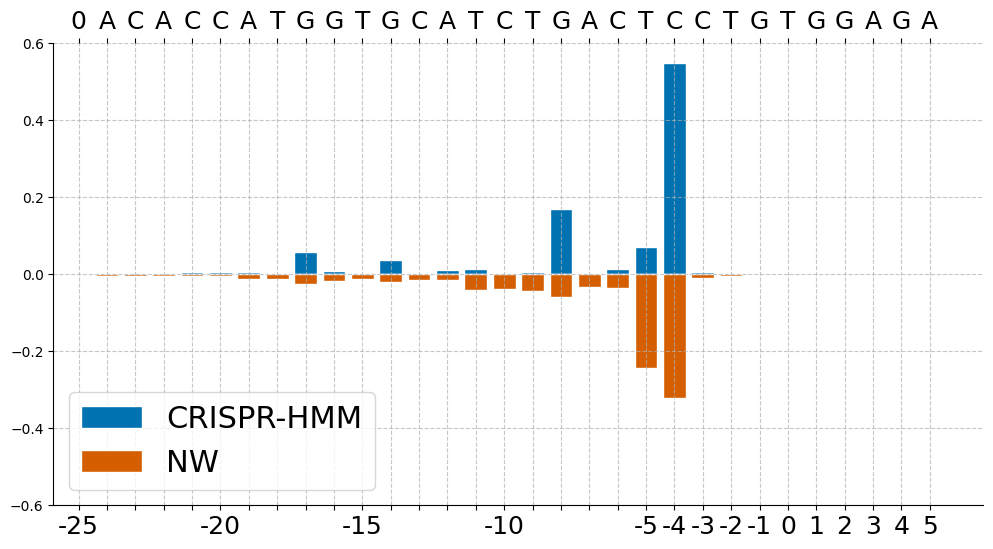

In [15]:
fig, ax = plt.subplots(figsize=(12, 6))

# Create the first histogram
weights1 = np.ones_like(HMM_deletion_start) / len(HMM_deletion_start)
weights2 = np.ones_like(NW_deletion_start) / len(NW_deletion_start)

max_pos = 31
pam_pos = 25
bin_edges = np.arange(0.5, max_pos+0.5)
pos = [j for j in range(max_pos)]
pos_tick = [str(i-pam_pos) if abs(i-pam_pos)<6 or (i-pam_pos) % 5 == 0 else "" for i in range(max_pos)]
bar_labels = ["0"] + [j for j in ref]
bar_labels = bar_labels[:max_pos]

plt.hist(HMM_deletion_start, bins=bin_edges, edgecolor='white', alpha=1, \
         label='CRISPR-HMM', weights=weights1, rwidth=0.8, color='#0072B2')
n, bins, patches = plt.hist(NW_deletion_start, bins=bin_edges, edgecolor='white', \
         alpha=1, label='NW', weights=weights2, rwidth=0.8, color='#D55E00')
for patch in patches:
    patch.set_height(-patch.get_height())

# Customize x-axis
ax.set_xticks(pos)
ax.set_xticklabels(pos_tick, fontsize=18)

# Customize y-axis
ax.set_ylim((-0.6, 0.6))

# Customize grid
ax.xaxis.grid(True, linestyle='--', alpha=0.7)
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Create a secondary x-axis on the top
ax2 = ax.twiny()

# Set the tick positions and labels for the secondary x-axis
ax2.set_xticks(pos)
ax2.set_xticklabels(bar_labels, fontsize=18)

# Remove the spines for the secondary x-axis
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)

# Align the secondary x-axis with the primary x-axis
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(ax.get_xticks())

# Add a legend
ax.legend(loc='lower left', fontsize=22)

# Show the plot
plt.show()

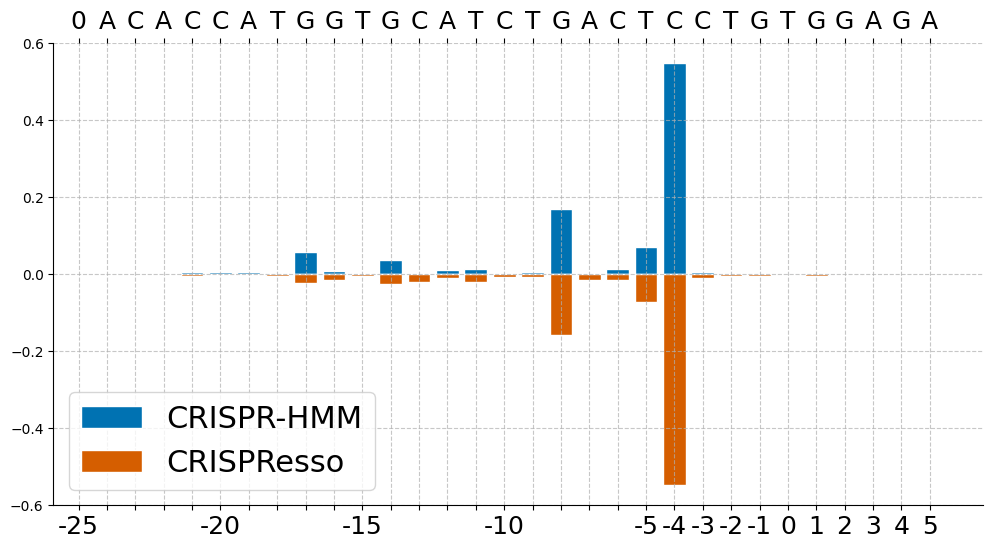

In [17]:
fig, ax = plt.subplots(figsize=(12, 6))

# Create the first histogram
weights1 = np.ones_like(HMM_deletion_start) / len(HMM_deletion_start)
weights2 = np.ones_like(CRISPResso_deletion_start) / len(CRISPResso_deletion_start)

max_pos = 31
pam_pos = 25
bin_edges = np.arange(0.5, max_pos+0.5)
pos = [j for j in range(max_pos)]
pos_tick = [str(i-pam_pos) if abs(i-pam_pos)<6 or (i-pam_pos) % 5 == 0 else "" for i in range(max_pos)]
bar_labels = ["0"] + [j for j in ref]
bar_labels = bar_labels[:max_pos]

plt.hist(HMM_deletion_start, bins=bin_edges, edgecolor='white', alpha=1, \
         label='CRISPR-HMM', weights=weights1, rwidth=0.8, color='#0072B2')
n, bins, patches = plt.hist(CRISPResso_deletion_start, bins=bin_edges, edgecolor='white', \
         alpha=1, label='CRISPResso', weights=weights2, rwidth=0.8, color='#D55E00')
for patch in patches:
    patch.set_height(-patch.get_height())

# Customize x-axis
ax.set_xticks(pos)
ax.set_xticklabels(pos_tick, fontsize=18)

# Customize y-axis
ax.set_ylim((-.6, .6))

# Customize grid
ax.xaxis.grid(True, linestyle='--', alpha=0.7)
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Create a secondary x-axis on the top
ax2 = ax.twiny()

# Set the tick positions and labels for the secondary x-axis
ax2.set_xticks(pos)
ax2.set_xticklabels(bar_labels, fontsize=18)

# Remove the spines for the secondary x-axis
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)

# Align the secondary x-axis with the primary x-axis
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(ax.get_xticks())

# Add a legend
ax.legend(loc='lower left', fontsize=22)

# Show the plot
plt.show()

In [19]:
HMM_insertion_start = [i.find("-") for i in HMM_result["aligned_ref"]]
HMM_insertion_start = [i for i in HMM_insertion_start if i != -1 and i < len(ref)]

NW_insertion_start = [i.find("-") for i in NW_result["aligned_ref"]]
NW_insertion_start = [i for i in NW_insertion_start if i != -1 and i < len(ref)]

CRISPResso_insertion_start = [i.find("-") for i in list(CRISPResso_result["aligned_ref"])]
CRISPResso_insertion_start = [i for i in CRISPResso_insertion_start if i != -1 and i < len(ref)]

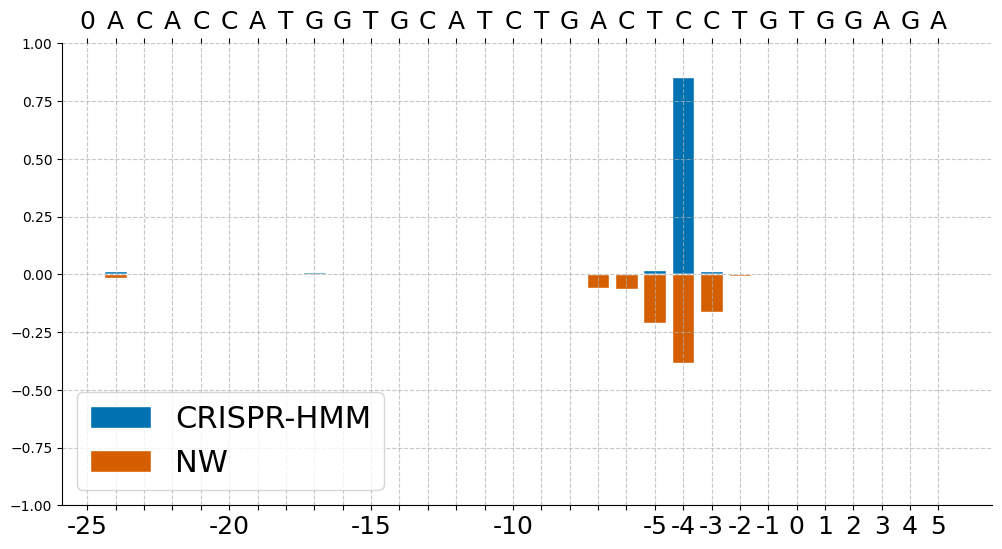

In [21]:
fig, ax = plt.subplots(figsize=(12, 6))

# Create the first histogram
weights1 = np.ones_like(HMM_insertion_start) / len(HMM_insertion_start)
weights2 = np.ones_like(NW_insertion_start) / len(NW_insertion_start)

max_pos = 31
pam_pos = 25
bin_edges = np.arange(0.5, max_pos+0.5)
pos = [j for j in range(max_pos)]
pos_tick = [str(i-pam_pos) if abs(i-pam_pos)<6 or (i-pam_pos) % 5 == 0 else "" for i in range(max_pos)]
bar_labels = ["0"] + [j for j in ref]
bar_labels = bar_labels[:max_pos]

plt.hist(HMM_insertion_start, bins=bin_edges, edgecolor='white', alpha=1, \
         label='CRISPR-HMM', weights=weights1, rwidth=0.8, color='#0072B2')
n, bins, patches = plt.hist(NW_insertion_start, bins=bin_edges, edgecolor='white', \
         alpha=1, label='NW', weights=weights2, rwidth=0.8, color='#D55E00')
for patch in patches:
    patch.set_height(-patch.get_height())

# Customize x-axis
ax.set_xticks(pos)
ax.set_xticklabels(pos_tick, fontsize=18)

# Customize y-axis
ax.set_ylim((-1., 1.))

# Customize grid
ax.xaxis.grid(True, linestyle='--', alpha=0.7)
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Create a secondary x-axis on the top
ax2 = ax.twiny()

# Set the tick positions and labels for the secondary x-axis
ax2.set_xticks(pos)
ax2.set_xticklabels(bar_labels, fontsize=18)

# Remove the spines for the secondary x-axis
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)

# Align the secondary x-axis with the primary x-axis
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(ax.get_xticks())

# Add a legend
ax.legend(loc='lower left', fontsize=22)

# Show the plot
plt.show()

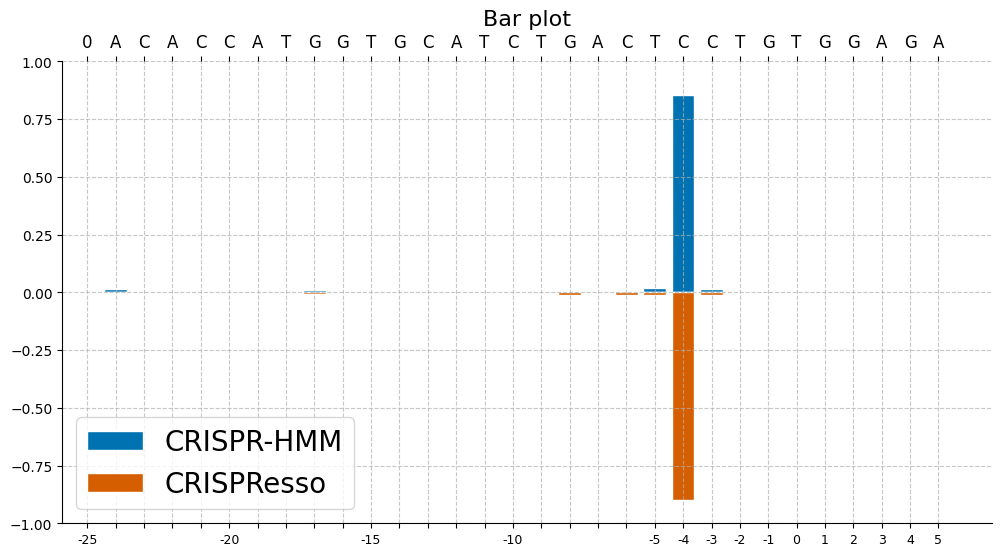

In [12]:
fig, ax = plt.subplots(figsize=(12, 6))

# Create the first histogram
weights1 = np.ones_like(HMM_insertion_start) / len(HMM_insertion_start)
weights2 = np.ones_like(CRISPResso_insertion_start) / len(CRISPResso_insertion_start)

max_pos = 31
pam_pos = 25
bin_edges = np.arange(0.5, max_pos+0.5)
pos = [j for j in range(max_pos)]
pos_tick = [str(i-pam_pos) if abs(i-pam_pos)<6 or (i-pam_pos) % 5 == 0 else "" for i in range(max_pos)]
bar_labels = ["0"] + [j for j in ref]
bar_labels = bar_labels[:max_pos]

plt.hist(HMM_insertion_start, bins=bin_edges, edgecolor='white', alpha=1, \
         label='CRISPR-HMM', weights=weights1, rwidth=0.8, color='#0072B2')
n, bins, patches = plt.hist(CRISPResso_insertion_start, bins=bin_edges, edgecolor='white', \
         alpha=1, label='CRISPResso', weights=weights2, rwidth=0.8, color='#D55E00')
for patch in patches:
    patch.set_height(-patch.get_height())

# Customize x-axis
ax.set_xticks(pos)
ax.set_xticklabels(pos_tick, fontsize=9)

# Customize y-axis
ax.set_ylim((-1, 1))

# Add title
ax.set_title("Bar plot", fontsize=16)

# Customize grid
ax.xaxis.grid(True, linestyle='--', alpha=0.7)
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Create a secondary x-axis on the top
ax2 = ax.twiny()

# Set the tick positions and labels for the secondary x-axis
ax2.set_xticks(pos)
ax2.set_xticklabels(bar_labels, fontsize=12)

# Remove the spines for the secondary x-axis
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)

# Align the secondary x-axis with the primary x-axis
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(ax.get_xticks())

# Add a legend
ax.legend(loc='lower left', fontsize=20)

# Show the plot
plt.show()

In [13]:
HMM_fake_result = pd.read_csv("./output/nhej_HMM_fake_result.csv")
NW_fake_result = pd.read_csv("./output/nhej_NW_fake_result.csv")


file_path = "./output/CRISPResso/CRISPResso_on_nhej_fake/fake.CRISPResso_output.fastq.gz"

CRISPResso_result_fake_fq = []
with gzip.open(file_path, "r") as file:
    while True:
        line1 = file.readline()
        line2 = file.readline()
        line3 = file.readline()
        line4 = file.readline()
        if not line2:
            break

        CRISPResso_result_fake_fq.append(line3.decode().strip())
        
fake_CRISPResso_result = {"score": [float(i.split(" ")[2][11:]) for i in CRISPResso_result_fake_fq],
                     "aligned_ref":[i.split(" ")[-2][8:] for i in CRISPResso_result_fake_fq],
                     "aligned_read":[i.split(" ")[-1][8:] for i in CRISPResso_result_fake_fq]
                    }
fake_CRISPResso_result = pd.DataFrame(data=fake_CRISPResso_result)

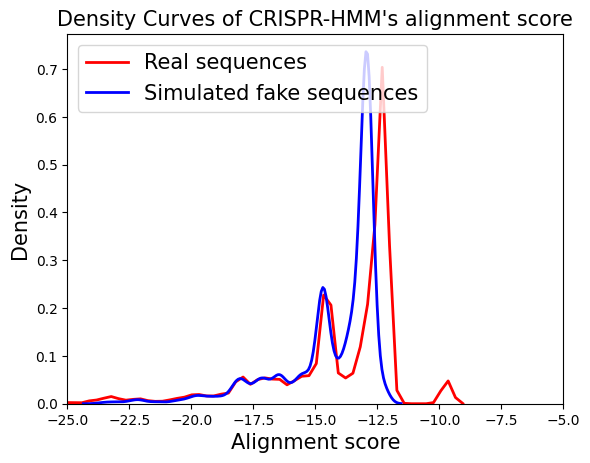

In [14]:
import seaborn as sns

HMM_likelihood = list(HMM_result[HMM_result["aligned_ref"] != HMM_result["aligned_read"]]["score"])
fake_HMM_likelihood = list(HMM_fake_result["score"])

# Define the number of bins and the bin edges
# Create histograms
# plt.hist(fake_HMM_likelihood, bins=bin_edges, alpha=0.5, edgecolor='white', \
#          color='red', label='Likelihood of fake sequences', density=True)
# plt.hist(HMM_likelihood, bins=bin_edges, alpha=0.5, edgecolor='white', \
#          color='blue', label='Likelihood of real sequences', density=True)

plt.xlim(-25, -5)
# plt.ylim(0, 0.15)
# Add density curves
sns.kdeplot(HMM_likelihood, color='red', lw=2, label='Real sequences')
sns.kdeplot(fake_HMM_likelihood, color='blue', lw=2, label='Simulated fake sequences')

# Customize plot appearance
plt.title("Density Curves of CRISPR-HMM's alignment score", fontsize=15)
plt.xlabel('Alignment score', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.legend(loc='upper left', fontsize=15)

# Show the plot
plt.show()

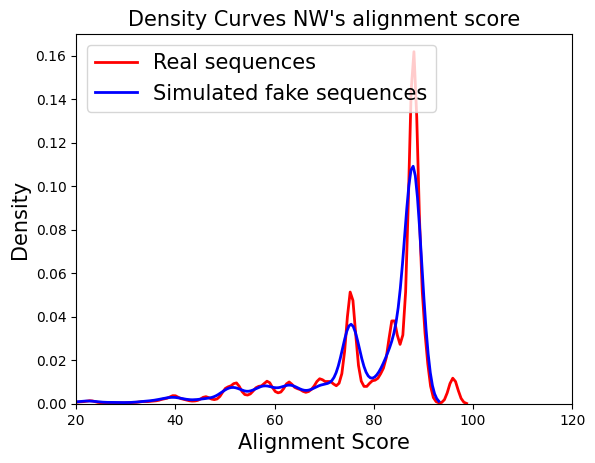

In [15]:
import seaborn as sns

NW_score = list(NW_result[NW_result["aligned_ref"] != NW_result["aligned_read"]]["score"])
fake_NW_score = list(NW_fake_result["score"])

# Define the number of bins and the bin edges
num_bins = 30
bin_edges = np.linspace(min(min(NW_score), min(fake_NW_score)), \
                        max(max(NW_score), max(fake_NW_score)), num_bins + 1)

# Create histograms
# plt.hist(fake_NW_score, bins=bin_edges, alpha=0.5, edgecolor='white', \
#          color='red', label='Likelihood of fake sequences', density=True)
# plt.hist(NW_score, bins=bin_edges, alpha=0.5, edgecolor='white', \
#          color='blue', label='Likelihood of real sequences', density=True)

plt.xlim(20, 120)
# plt.ylim(0, 0.35)
# Add density curves
sns.kdeplot(NW_score, color='red', lw=2, label='Real sequences')
sns.kdeplot(fake_NW_score, color='blue', lw=2, label='Simulated fake sequences')

# Customize plot appearance
plt.title("Density Curves NW's alignment score", fontsize=15)
plt.xlabel('Alignment Score', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.legend(loc='upper left', fontsize=15)

# Show the plot
plt.show()

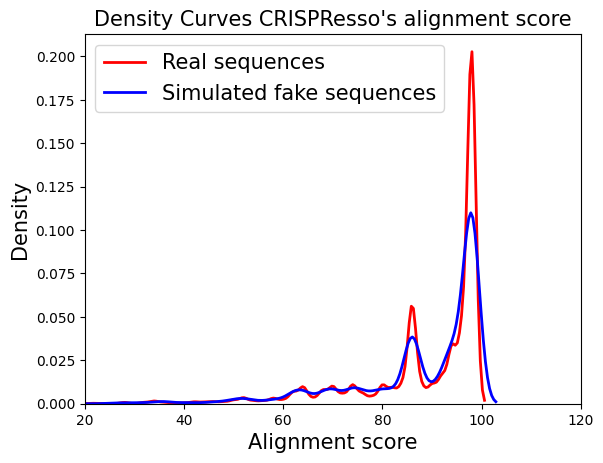

In [16]:
CRISPResso_score = list(CRISPResso_result[CRISPResso_result["aligned_ref"] != CRISPResso_result["aligned_read"]]["score"])
fake_CRISPResso_score = list(fake_CRISPResso_result["score"])

# Define the number of bins and the bin edges

plt.xlim(20, 120)
# plt.ylim(0, 0.35)
# Add density curves
sns.kdeplot(CRISPResso_score, color='red', lw=2, label='Real sequences')
sns.kdeplot(fake_CRISPResso_score, color='blue', lw=2, label='Simulated fake sequences')

# Customize plot appearance
plt.title("Density Curves CRISPResso's alignment score", fontsize=15)
plt.xlabel('Alignment score', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.legend(loc='upper left', fontsize=15)

# Show the plot
plt.show()

In [17]:
def del_length_to_string(l):
    if l < 10:
        return str(l)
    return "10+"

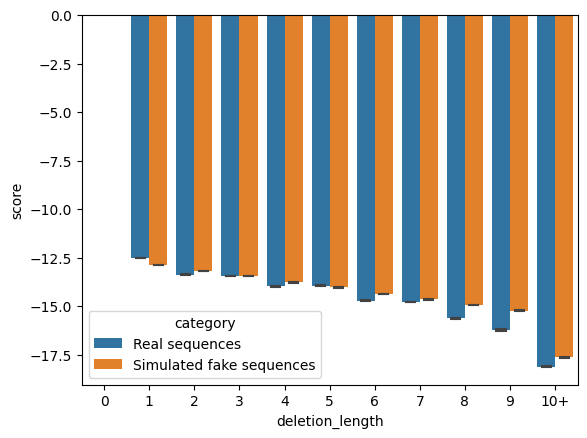

In [18]:
HMM_result["deletion_length"] = [i.count("-") for i in HMM_result["aligned_read"]]
HMM_result["deletion_length"] = [del_length_to_string(i) for i in HMM_result["deletion_length"]]
HMM_result["category"] = "Real sequences"
HMM_fake_result["deletion_length"] = [i.count("-") for i in HMM_fake_result["aligned_read"]]
HMM_fake_result["deletion_length"] = [del_length_to_string(i) for i in HMM_fake_result["deletion_length"]]
HMM_fake_result["category"] = "Simulated fake sequences"

df = pd.concat([HMM_result,HMM_fake_result])
df = df[df["deletion_length"]!="0"]
order = [str(i) for i in range(10)] + ["10+"]
sns.barplot(x="deletion_length", y="score", hue="category", data=df, order=order, capsize=0.2, errwidth=1.5)
plt.show()

In [19]:
CRISPResso_result["deletion_length"] = [i.count("-") for i in CRISPResso_result["aligned_read"]]
CRISPResso_result["deletion_length"] = [del_length_to_string(i) for i in CRISPResso_result["deletion_length"]]
CRISPResso_result["category"] = "Real sequences"
fake_CRISPResso_result["deletion_length"] = [i.count("-") for i in fake_CRISPResso_result["aligned_read"]]
fake_CRISPResso_result["deletion_length"] = [del_length_to_string(i) for i in fake_CRISPResso_result["deletion_length"]]
fake_CRISPResso_result["category"] = "Simulated fake sequences"

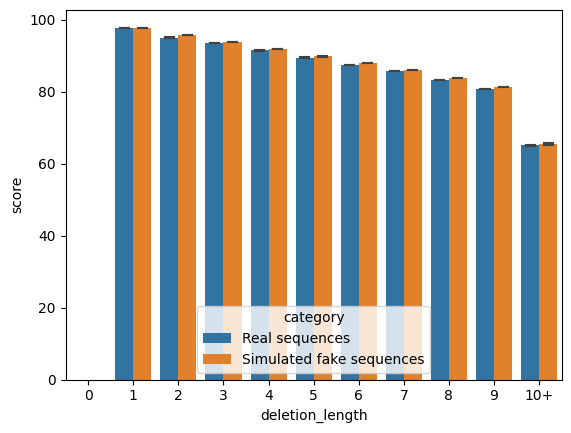

In [20]:
df = pd.concat([CRISPResso_result,fake_CRISPResso_result])
df = df[df["deletion_length"]!="0"]
order = [str(i) for i in range(10)] + ["10+"]
sns.barplot(x="deletion_length", y="score", hue="category", data=df, order=order, capsize=0.2, errwidth=1.5)
plt.show()

In [50]:
def find_single_deletion_positions(dna_sequence):
    # Find start and end positions
    start_position = dna_sequence.find('-')
    end_position = dna_sequence.rfind('-')

    # Check if '-' is found in the sequence and it's a single continuous deletion
    if start_position == -1 or end_position == -1 or dna_sequence[start_position:end_position+1].count('-') != end_position - start_position + 1:
        return "None"

    # As Python uses 0-indexing, add 1 to each position to match biological 1-indexing
    if start_position + 1 == 22 or end_position + 1 == 22:
        return "alt-NHEJ"
    return "c-NHEJ"

In [51]:
from collections import Counter
hmm_outcome = [find_single_deletion_positions(i) for i in list(HMM_result["aligned_read"])]
hmm_outcome = Counter(hmm_outcome)
hmm_outcome.pop("None")
hmm_outcome

Counter({'c-NHEJ': 373921, 'alt-NHEJ': 481435})

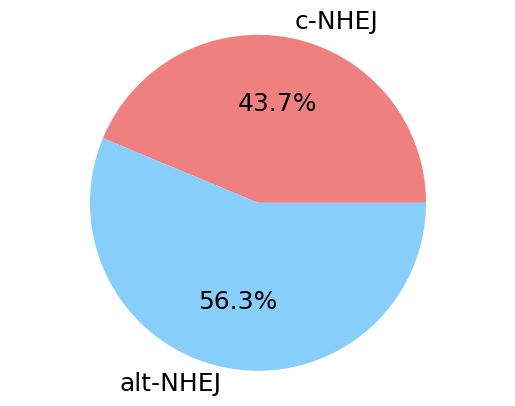

In [65]:
colors = ['lightcoral', 'lightskyblue']

# Create pie chart
patches, texts, autotexts = plt.pie(list(hmm_outcome.values()), labels=list(hmm_outcome.keys()), colors=colors, autopct='%1.1f%%')

# Increase the size of the labels
for text in texts:
    text.set_size(18)
for autotext in autotexts:
    autotext.set_size(18)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')

# Display the chart
plt.show()

In [54]:
from collections import Counter
nw_outcome = [find_single_deletion_positions(i) for i in list(NW_result["aligned_read"])]
nw_outcome = Counter(nw_outcome)
nw_outcome.pop("None")
nw_outcome

Counter({'c-NHEJ': 516964, 'alt-NHEJ': 336862})

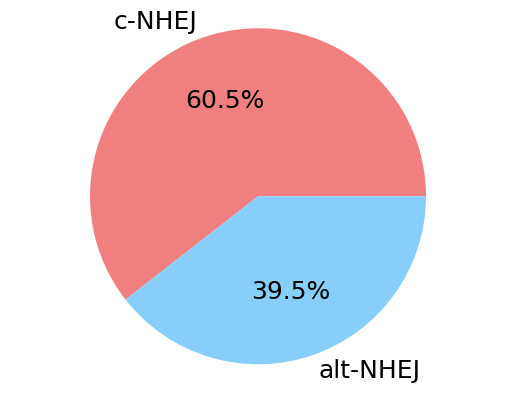

In [64]:
colors = ['lightcoral', 'lightskyblue']

# Create pie chart
patches, texts, autotexts = plt.pie(list(nw_outcome.values()), labels=list(nw_outcome.keys()), colors=colors, autopct='%1.1f%%')

# Increase the size of the labels
for text in texts:
    text.set_size(18)
for autotext in autotexts:
    autotext.set_size(18)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')

# Display the chart
plt.show()

In [56]:
from collections import Counter
crispresso_outcome = [find_single_deletion_positions(i) for i in list(CRISPResso_result["aligned_read"])]
crispresso_outcome = Counter(crispresso_outcome)
crispresso_outcome.pop("None")
crispresso_outcome

Counter({'c-NHEJ': 369804, 'alt-NHEJ': 484552})

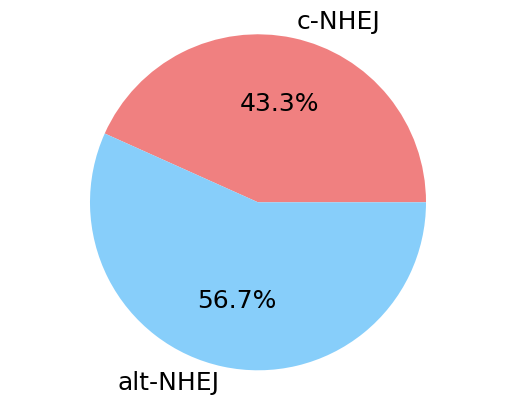

In [63]:
colors = ['lightcoral', 'lightskyblue']

# Create pie chart
patches, texts, autotexts = plt.pie(list(crispresso_outcome.values()), labels=list(crispresso_outcome.keys()), colors=colors, autopct='%1.1f%%')

# Increase the size of the labels
for text in texts:
    text.set_size(18)
for autotext in autotexts:
    autotext.set_size(18)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')

# Display the chart
plt.show()